## Spark Context and Imports

In [1]:
import os, re, sys, utilities
spark_home = os.environ.get('SPARK_HOME', None)

In [2]:
import sys
sys.version_info

sys.version_info(major=3, minor=6, micro=8, releaselevel='final', serial=0)

In [3]:
code = utilities.getSparkContext()
exec(code)

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 2.3.2.3.1.4.26-3
      /_/

Using Python version 3.6.8 (default, Dec 30 2018 01:22:34)
SparkSession available as 'spark'.


In [4]:
from pyspark import SparkContext
#from pyspark.sql import SparkSession, HiveContext

In [5]:
from pyspark_llap.sql.session import HiveWarehouseSession
from pyspark.sql import SparkSession

hive = HiveWarehouseSession.session(spark).build()

In [6]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import datetime
import math
import scipy

In [7]:
from pyspark.sql.functions import col, udf, countDistinct, isnan, when, count, to_date, from_unixtime, unix_timestamp, min, max, row_number
from pyspark.sql.window import Window
from pyspark.sql.types import Row
from pyspark.sql.functions import year, month, dayofmonth, hour

In [8]:
from pyspark.sql.types import DoubleType, FloatType, BooleanType, LongType, \
IntegerType, TimestampType, StringType, StructType, StructField, ArrayType

In [11]:
import matplotlib.dates as mdates

## Master Table - Parquet File Creation 
### Read Trip Summary Table (filtered using query)

In [ ]:
# filtered trip summary data, original
trip_sum_NA_raw = spark.sql("""SELECT T1.cvdcqa_vin_d_3 AS vin,
coalesce(T1.cvdcqa_oil_chng_cyc_no_r_3,0) AS oil_change_cycle_number,
T1.cvdcqa_trip_no_r_3 AS trip_number,
to_date(T1.cvdcqa_trip_end_time_s_3) AS trip_end_date,
T1.cvdcqa_trip_end_eng_oil_p_3 AS trip_end_eng_oil_percent,
T1.cvdcqa_trip_end_odo_read_r_3 AS trip_end_odo_read
FROM cvdp.NCVDCQA_TRIP_SUM_FINAL_SEC_HTE T1
WHERE T1.cvdcqa_suspect_flag_r_3 = 0 AND
T1.cvdcqa_trip_no_r_3 IS NOT NULL AND
T1.cvdcqa_trip_end_time_s_3 IS NOT NULL AND
T1.cvdcqa_trip_end_eng_oil_p_3 IS NOT NULL AND
T1.cvdcqa_trip_end_odo_read_r_3 IS NOT NULL AND
T1.cvdcqa_vin_d_3 IS NOT NULL AND
T1.cvdcqa_partition_cntry_x = 'USA' AND
year(T1.cvdcqa_trip_end_time_s_3) > 2015""")

In [8]:
# filtered trip summary data
#to_timestamp(T1.cvdcqa_trip_end_time_s_3) AS trip_end_date,
trip_sum_EU = spark.sql("""SELECT T1.cvdcqa_vin_d_3 AS vin,
to_date(T1.cvdcqa_trip_end_time_s_3) as trip_end_date,
split(to_timestamp(T1.cvdcqa_trip_end_time_s_3),' ')[1] as trip_end_time,
from_unixtime(unix_timestamp(T1.cvdcqa_trip_end_time_s_3),'EEEE') as weekday,
T1.cvdcqa_mvemodyr7 AS model_year,
T1.cvdcqa_vehicle_description888_x_3 AS veh_dsc,
row_number() over(order by T1.cvdcqa_vin_d_3, T1.cvdcqa_trip_end_time_s_3) as msg_id
FROM cvdp.NCVDCQA_TRIP_SUM_FINAL_SEC_HTE T1
WHERE T1.cvdcqa_suspect_flag_r_3 = 0 AND
T1.cvdcqa_trip_no_r_3 IS NOT NULL AND
T1.cvdcqa_trip_end_time_s_3 IS NOT NULL AND
T1.cvdcqa_trip_end_odo_read_r_3 IS NOT NULL AND
T1.cvdcqa_vin_d_3 IS NOT NULL AND
T1.cvdcqa_partition_region_x = 'EU' AND
year(T1.cvdcqa_trip_end_time_s_3) > 2015""")

In [9]:
trip_sum_EU.show(5)

+-----------------+-------------+-------------+-------+----------+--------------------+------+
|              vin|trip_end_date|trip_end_time|weekday|model_year|             veh_dsc|msg_id|
+-----------------+-------------+-------------+-------+----------+--------------------+------+
|1FA6P8CF0K5172769|   2019-09-20|     18:24:12| Friday|      2019|FORD  MUSTANG 2-D...|     1|
|1FA6P8CF0K5172769|   2019-09-20|     18:56:50| Friday|      2019|FORD  MUSTANG 2-D...|     2|
|1FA6P8CF0K5172769|   2019-09-20|     19:15:39| Friday|      2019|FORD  MUSTANG 2-D...|     3|
|1FA6P8CF0K5172769|   2019-09-20|     19:16:09| Friday|      2019|FORD  MUSTANG 2-D...|     4|
|1FA6P8CF0K5172769|   2019-09-20|     19:16:12| Friday|      2019|FORD  MUSTANG 2-D...|     5|
+-----------------+-------------+-------------+-------+----------+--------------------+------+
only showing top 5 rows



In [ ]:
# filtered trip summary data
# without row ID 
trip_sum_EU = spark.sql("""SELECT T1.cvdcqa_vin_d_3 AS vin,
to_date(T1.cvdcqa_trip_end_time_s_3) as trip_end_date,
split(to_timestamp(T1.cvdcqa_trip_end_time_s_3),' ')[1] as trip_end_time,
from_unixtime(unix_timestamp(T1.cvdcqa_trip_end_time_s_3),'EEEE') as weekday,
T1.cvdcqa_mvemodyr7 AS model_year,
FROM cvdp.NCVDCQA_TRIP_SUM_FINAL_SEC_HTE T1
ORDER BY T1.cvdcqa_vin_d_3, T1.cvdcqa_trip_end_time_s_3
WHERE T1.cvdcqa_suspect_flag_r_3 = 0 AND
T1.cvdcqa_trip_no_r_3 IS NOT NULL AND
T1.cvdcqa_trip_end_time_s_3 IS NOT NULL AND
T1.cvdcqa_trip_end_odo_read_r_3 IS NOT NULL AND
T1.cvdcqa_vin_d_3 IS NOT NULL AND
T1.cvdcqa_partition_region_x = 'EU' AND
year(T1.cvdcqa_trip_end_time_s_3) > 2015""")

In [ ]:
#how to split datetime in query
#ex = spark.sql("""with t as (select timestamp '2017-04-06 04:20:33' as dt) 
#select to_date(dt) as date, split(dt,' ')[1] from t as time""")
ex = spark.sql("""with t as (select'2017-04-06 04:20:33' as dt) 
select to_date(dt) as date, split(dt,' ')[1] as time, from_unixtime(unix_timestamp(dt),'EEEE') as week from t""")

In [ ]:
ex.show()

In [ ]:
#add message ID index column
# This will return a new DF with all the columns + id
#trip_sum_EU = df.withColumn("msg_id",monotonically_increasing_id())

#use this instead
w = Window.orderBy("trip_end_time") 
#w = Window.partitionBy("vin").orderBy("trip_end_time")
trip_sum_EU = df.withColumn("index", row_number().over(w))

In [ ]:
trip_sum_EU.printSchema()
#trip_sum_NA_raw.printSchema()

In [ ]:
trip_sum_EU.show(5)

In [ ]:
trip_sum_EU.count()

In [ ]:
# max and min MY for TS table
#mv1 = trip_sum_EU.agg({"model_year": "max"}).collect()[0][0]
trip_sum_EU.select([ min("model_year"), max("model_year")]).show()

In [ ]:
#model Year distribution
trip_sum_EU.groupby(trip_sum_EU.model_year).count()

### Get engine and trans info from Vin Dim

In [8]:
# vin dimension table for EU
vin_dim = spark.sql("select vin, vehicle_line_description, model_year, engine, transmission from  gdiaveh1.vin_dimension where ford_sale_region = 'Europe'");

In [ ]:
vin_dim.show(5)

In [ ]:
#how many engine types?
vin_dim.select("engine").distinct().count()

In [ ]:
#how many vehicle types?
vin_dim.select("vehicle_line_description").distinct().count()

In [ ]:
#vehicle line description 
vin_dim.select("vehicle_line_description").distinct().show()

In [ ]:
#MY range
vin_dim.select([ min("model_year"), max("model_year")]).show()

### join vin dim to trip sum 

In [9]:
#left_join = adas.join(tnediccaTX, adas.vin == tnediccaTX.vin, how='left_outer')
left_join = trip_sum_EU.join(vin_dim["vin", "vehicle_line_description", "engine", "transmission"], ["vin"], how='left')

In [ ]:
left_join.show(5)

In [ ]:
left_join.count()

In [ ]:
#vin_dim.filter((trip_sum_EU_raw["cvdcqa_suspect_flag_r_3"] != "0")).count()

In [10]:
#save as parquet file in S drive
#random bnb code - check - T6P3Sv9uNX or 96yfP2UnG0 81DtSWJmN0 paulap14037 kellyk3705
#tripsum_EU = left_join.toPandas()
left_join.write.parquet('hdfs://hdp2cluster/user/lguerra5/IOLM_EU/EU_tripsum_vindim.parquet')

## Start here after creating parquet file

### Read Parquet file from hdfs

In [9]:
# using SQLContext to read parquet file
#from pyspark.sql import SQLContext
#sqlContext = SQLContext(SparkContext)

# to read parquet file
tripsum_EU = spark.read.parquet('hdfs://hdp2cluster/user/lguerra5/IOLM_EU/*')

In [10]:
tripsum_EU.printSchema()

root
 |-- vin: string (nullable = true)
 |-- trip_end_date: date (nullable = true)
 |-- trip_end_time: string (nullable = true)
 |-- weekday: string (nullable = true)
 |-- model_year: integer (nullable = true)
 |-- veh_dsc: string (nullable = true)
 |-- msg_id: integer (nullable = true)
 |-- vehicle_line_description: string (nullable = true)
 |-- engine: string (nullable = true)
 |-- transmission: string (nullable = true)



In [12]:
tripsum_EU.show(5)

+-----------------+-------------+-------------+--------+----------+--------------------+------+------------------------+--------------------+--------------------+
|              vin|trip_end_date|trip_end_time| weekday|model_year|             veh_dsc|msg_id|vehicle_line_description|              engine|        transmission|
+-----------------+-------------+-------------+--------+----------+--------------------+------+------------------------+--------------------+--------------------+
|1FA6P8CF6L5104901|   2020-01-21|     13:48:19| Tuesday|      2020|Mustang 2015     ...|  9080|           S550n Mustang|Mod 5.0l-4v Dohc ...|6 Spd Man Trans-mt82|
|1FA6P8CF9L5110059|   2020-01-04|     13:53:25|Saturday|      2020|Mustang 2015     ...| 13793|           S550n Mustang|Mod 5.0l-4v Dohc ...|6 Spd Man Trans-mt82|
|1FA6P8CF9L5110059|   2020-01-04|     14:04:21|Saturday|      2020|Mustang 2015     ...| 13794|           S550n Mustang|Mod 5.0l-4v Dohc ...|6 Spd Man Trans-mt82|
|1FA6P8CF9L5110059|   

In [12]:
#check nulls
from pyspark.sql import functions as F
#tripsum_EU.filter((tripsum_EU["vehicle_line_description"] == "null")).count()
tripsum_EU.where(F.isnull(F.col("vehicle_line_description"))).count()

167696668

In [21]:
tripsum_EU.where(F.isnull(F.col("engine"))).count()

555908

In [22]:
tripsum_EU.where(F.isnull(F.col("transmission"))).count()

555908

In [18]:
tripsum_EU.count()

184926926

In [24]:
float(167696668/184926926)
float(555908/184926926)*100

0.3006095499581278

In [10]:
tripsum_EU.select([ min("model_year"), max("model_year")]).show()

+---------------+---------------+
|min(model_year)|max(model_year)|
+---------------+---------------+
|           2015|           2020|
+---------------+---------------+



### Grab some 2019-2020 VINS

In [11]:
tripsum_EU_new = tripsum_EU[(tripsum_EU.model_year > 2018)].drop_duplicates(subset =["vin"])

In [14]:
# dropping ALL duplicte values 
tripsum_EU_new.drop_duplicates(subset =["vin"]).show(10)

DataFrame[vin: string, trip_end_date: date, trip_end_time: string, weekday: string, model_year: int, veh_dsc: string, msg_id: int, vehicle_line_description: string, engine: string, transmission: string]

In [23]:
tripsum_EU_new.orderBy('vin', ascending=False).show(10)

+-----------------+-------------+-------------+-------+----------+--------------------+---------+------------------------+------+------------+
|              vin|trip_end_date|trip_end_time|weekday|model_year|             veh_dsc|   msg_id|vehicle_line_description|engine|transmission|
+-----------------+-------------+-------------+-------+----------+--------------------+---------+------------------------+------+------------+
|WF0ZXXTTGZLB75432|   2020-01-21|     06:33:45|Tuesday|      2020|Transit Custom   ...|184926921|                    null|  null|        null|
|WF0ZXXTTGZLB75432|   2020-01-21|     11:50:09|Tuesday|      2020|Transit Custom   ...|184926922|                    null|  null|        null|
|WF0ZXXTTGZLB75432|   2020-01-21|     12:17:30|Tuesday|      2020|Transit Custom   ...|184926923|                    null|  null|        null|
|WF0ZXXTTGZLB75432|   2020-01-21|     06:30:06|Tuesday|      2020|Transit Custom   ...|184926920|                    null|  null|        null|

In [20]:
tripsum_EU_new.sample(False, 0.1, seed=8).limit(10).show()

+-----------------+-------------+-------------+---------+----------+--------------------+------+------------------------+--------------------+--------------------+
|              vin|trip_end_date|trip_end_time|  weekday|model_year|             veh_dsc|msg_id|vehicle_line_description|              engine|        transmission|
+-----------------+-------------+-------------+---------+----------+--------------------+------+------------------------+--------------------+--------------------+
|1FA6P8NF5L5105387|   2020-01-10|     16:49:13|   Friday|      2020|Mustang 2015     ...| 23710|           S550n Mustang|Mod 5.0l-4v Dohc ...|6 Spd Man Trans-mt82|
|1FA6P8NF5L5105387|   2020-01-13|     16:26:05|   Monday|      2020|Mustang 2015     ...| 23711|           S550n Mustang|Mod 5.0l-4v Dohc ...|6 Spd Man Trans-mt82|
|1FA6P8NF5L5105387|   2020-01-14|     09:32:08|  Tuesday|      2020|Mustang 2015     ...| 23712|           S550n Mustang|Mod 5.0l-4v Dohc ...|6 Spd Man Trans-mt82|
|1FA6P8V00L51054

### Save grouped by object as .csv for limits compare

In [12]:
#get list of unique combos of model_year, vehicle_line_description, engine, transmission
df = tripsum_EU.groupBy("model_year", "veh_dsc", "engine", "transmission").agg(count("*"))
df.show()

+----------+--------------------+--------------------+--------------------+--------+
|model_year|             veh_dsc|              engine|        transmission|count(1)|
+----------+--------------------+--------------------+--------------------+--------+
|      2020|EcoSport 2018    ...|                null|                null|    1203|
|      2018|NAVIGATOR        ...|                null|                null|      14|
|      2020|FORD  ESCAPE 4-DR...|                null|                null|       7|
|      2018|FORD  F-150 SUPER...|                null|                null|    3810|
|      2019|Fiesta 2017      ...|1.0l 12v Di Tc I3...|6 Spd Man Trans G...|14013554|
|      2019|Fiesta 2017      ...|1.0l 12v Di Tc I3...|6 Spd Auto Trans ...| 3699919|
|      2018|Transit Connect -...|1.0l Tc Gas New F...|6 Spd Man Trans G...|   84855|
|      2020|Edge 2019        ...|2.0l Cr Tc Dsl Pa...|6 Sp Man Trans - ...|      26|
|      2019|FORD  ESCAPE 4-DR...|                null|           

In [29]:
df.repartition(1).write.format("csv").option("header", "True").save("hdfs://hdp2cluster/user/lguerra5/tripsum_EU_vehtypes")
#oilResetPd_week.to_csv("/s/lguerra5/oilReset"+START_DATE_2.replace("-","",2)+"_"+END_DATE_2.replace("-","",2)+".csv")

In [13]:
EU_veh_types = df.toPandas()

### Bring in Limits Config File

In [8]:
# read CSV file into dataframe
limits_df = (sqlContext.read
    .format("com.databricks.spark.csv")
    .options(inferSchema="true", delimiter=";", header="true")
    .load("limits_config_test.csv"))

AnalysisException: 'Path does not exist: hdfs://hdp2cluster/user/lguerra5/limits_config_test.csv;'

### Join to master table 

In [ ]:
#left_join = adas.join(tnediccaTX, adas.vin == tnediccaTX.vin, how='left_outer')
master_df = tripsum_EU.join(limits_df, ["vin"], how='left')

In [ ]:
master_df.show(5)

## EU Vehicle Message Load Profiling

In [ ]:
# Hourly plots, how many messages come in per day, per hour?

In [10]:
total_msg = tripsum_EU.count()

In [12]:
#tripsum_EU.groupBy("model_year", "veh_dsc", "engine", "transmission").agg(count("*"))
hp1 = tripsum_EU.groupBy(year("trip_end_date").alias("year"), month("trip_end_date").alias("month"), dayofmonth("trip_end_date").alias("day"),hour("trip_end_time").alias("hour")).count().orderBy("month").toPandas()

In [11]:
hp1.head()

year  month  day  hour  count
0  2020      1   17    22  12192
1  2020      1   14    15  38726
2  2020      1    2     5   9291
3  2020      1    9    22   7776
4  2020      1   21     3   1848

In [26]:
hp1.dtypes

year     int32
month    int32
day      int32
hour     int32
count    int64
dtype: object

In [26]:
hp1.year.min()

2017
2020


In [42]:
hp2 = hp1.groupby(['hour'], as_index=False)['count'].sum()

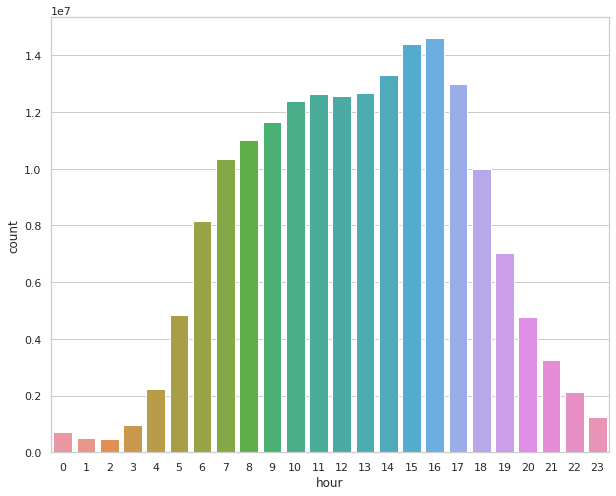

In [43]:
#set grid and font styles
sns.set(style="whitegrid")
#sns.set(font_scale=1.5)

#hourly distribution of messages 
size  = (10, 8)
fig, ax = plt.subplots(figsize = size)
#plt.xticks(rotation=45)
#ax = sns.distplot("hour","count", data=hp1, palette="plasma")
ax = sns.barplot(x="hour", y='count', data=hp2);

In [29]:
wp1 = tripsum_EU.groupBy("weekday").count().orderBy("weekday").toPandas()

In [30]:
wp1

weekday     count
0     Friday  30656829
1     Monday  27369829
2   Saturday  25746489
3     Sunday  19270255
4   Thursday  28059288
5    Tuesday  27353399
6  Wednesday  26470837

In [34]:
wp1.dtypes

weekday    object
count       int64
dtype: object

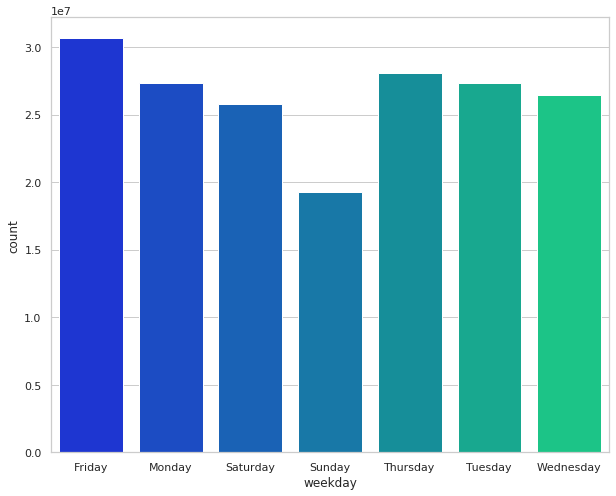

In [31]:
#set grid and font styles
sns.set(style="whitegrid")
#sns.set(font_scale=1.5)

#hourly distribution of messages 
size  = (10, 8)
fig, ax = plt.subplots(figsize = size)
ax = sns.barplot(x="weekday", y='count', data=wp1, palette="winter");

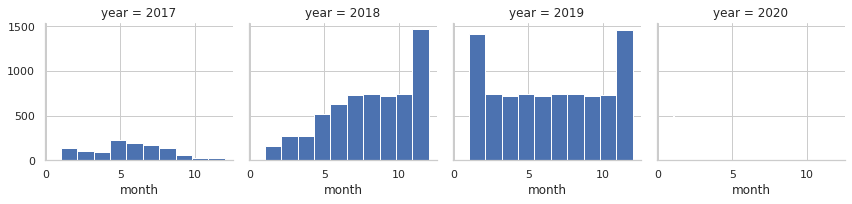

In [13]:
#df = sns.load_dataset('tips')
#size  = (15, 8)
#fig, ax = plt.subplots(figsize = size)
g = sns.FacetGrid(hp1, col = "year")
g.map(plt.hist, "month")
plt.show()

In [40]:
ex1 = hp1[(hp1['year']== 2017)].groupby(['month'], as_index=False)['count'].sum()
ex2 = hp1[(hp1['year']== 2018)].groupby(['month'], as_index=False)['count'].sum()
ex3 = hp1[(hp1['year']== 2019)].groupby(['month'], as_index=False)['count'].sum()
ex4 = hp1[(hp1['year']== 2020)].groupby(['month'], as_index=False)['count'].sum()

<Figure size 432x288 with 0 Axes>

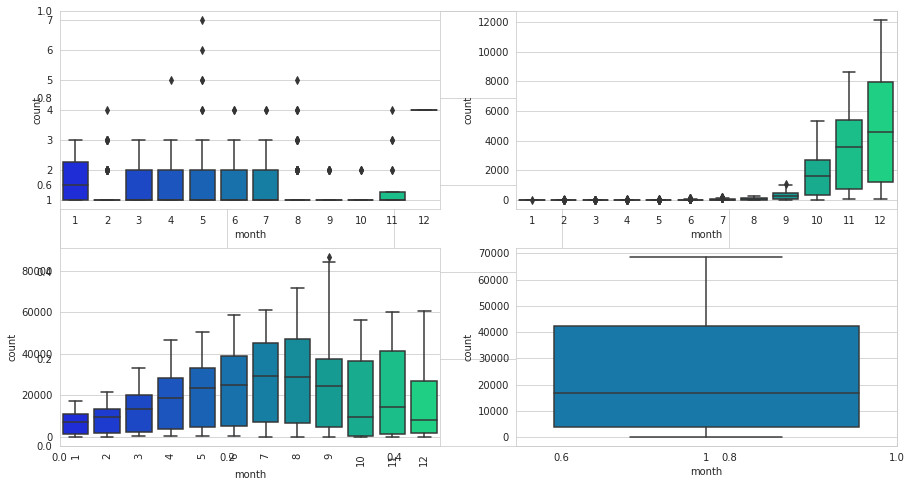

In [22]:
fig = plt.figure()
sns.set_style("whitegrid")
#sns.set_style("whitegrid", {'axes.grid' : False})
#fig.subplots_adjust(hspace=0.4, wspace=0.4)
size  = (15, 8)
fig, ax = plt.subplots(figsize = size)
ax = fig.add_subplot(2, 2, 1)
#sns.distplot(df.Principal,ax=ax)
ax = sns.boxplot(x="month", y="count", data=ex1, palette="winter")

ax = fig.add_subplot(2, 2, 2)
#sns.distplot(df.terms,ax=ax)
ax = sns.boxplot(x="month", y="count", data=ex2, palette="winter")

ax = fig.add_subplot(2, 2, 3)
ax = sns.boxplot(x="month", y="count", data=ex3, palette="winter")
#sns.barplot(data = df[['Less_than_College', 'college', 'Bachelor']],ax=ax)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax = fig.add_subplot(2, 2, 4)
#sns.boxplot(df['age'],ax=ax)
ax = sns.boxplot(x="month", y="count", data=ex4, palette="winter")
plt.show()

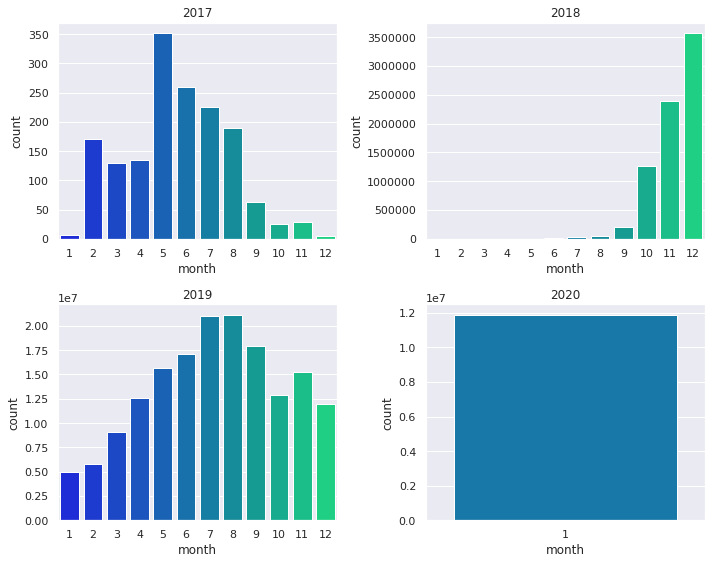

In [41]:
f = plt.figure(figsize=(10, 8))
gs = f.add_gridspec(2, 2)

with sns.axes_style("darkgrid"):
    ax = f.add_subplot(gs[0, 0])
    sns.barplot(x="month", y="count", data=ex1, palette="winter").set_title("2017")

with sns.axes_style("darkgrid"):
    ax = f.add_subplot(gs[0, 1])
    sns.barplot(x="month", y="count", data=ex2, palette="winter").set_title("2018")

with sns.axes_style("darkgrid"):
    ax = f.add_subplot(gs[1, 0])
    sns.barplot(x="month", y="count", data=ex3, palette="winter").set_title("2019")

with sns.axes_style("darkgrid"):
    ax = f.add_subplot(gs[1, 1])
    sns.barplot(x="month", y="count", data=ex4, palette="winter").set_title("2020")
  
f.tight_layout()

In [50]:
hp1.groupby(['year'], as_index=False)['count'].sum()

year      count
0  2017       1590
1  2018    7516150
2  2019  165504676
3  2020   11904510

## Country Code Analysis

In [10]:
TS = spark.sql("""SELECT T.cvdcqa_vin_d_3, cvdcqa_trip_end_time_s_3, T.cvdcqa_partition_cntry_x
FROM cvdp.NCVDCQA_TRIP_SUM_FINAL_SEC_HTE T
WHERE T.cvdcqa_suspect_flag_r_3 = 0 AND
T.cvdcqa_trip_end_time_s_3 IS NOT NULL AND
T.cvdcqa_vin_d_3 IS NOT NULL AND
T.cvdcqa_partition_region_x = 'EU' AND
year(T.cvdcqa_trip_end_time_s_3) > 2015""")

In [12]:
TCU4G = spark.sql('select cvdc62_bsbattsoc_r, cvdc62_odom_mstr_val_r, cvdc62_der_event_s_3, to_date(cvdc62_der_event_s_3) as message_date, cvdc62_vin_d_3, cvdc62_msg_metadata_msg_n, cvdc62_gps_longitude_decimaldegrees_r_3, cvdc62_gps_latitude_decimaldegrees_r_3, CVDC62_SLEEP_STAT_C from cvdp.ncvdc62_tcuftcp_msg_sec_hte \
where cvdc62_partition_region_x = "NA" and cvdc62_partition_country_x = "USA" and cvdc62_partition_date_x between "2019-12-01" and "2020-02-13" and to_date(cvdc62_der_event_s_3) between "2020-01-01" and "2020-02-11"')

In [14]:
TCU4G_EU = spark.sql('select cvdc62_bsbattsoc_r, cvdc62_odom_mstr_val_r, cvdc62_der_event_s_3, to_date(cvdc62_der_event_s_3) as message_date, cvdc62_vin_d_3, cvdc62_msg_metadata_msg_n, cvdc62_gps_longitude_decimaldegrees_r_3, cvdc62_gps_latitude_decimaldegrees_r_3, CVDC62_SLEEP_STAT_C from cvdp.ncvdc62_tcuftcp_msg_sec_hte \
where cvdc62_partition_region_x = "EU" and cvdc62_partition_country_x = "DEU" and cvdc62_partition_date_x between "2019-12-01" and "2020-02-13" and to_date(cvdc62_der_event_s_3) between "2020-01-01" and "2020-02-11"')

In [13]:
TCU4G.show(5)

+------------------+----------------------+--------------------+------------+--------------+-------------------------+---------------------------------------+--------------------------------------+-------------------+
|cvdc62_bsbattsoc_r|cvdc62_odom_mstr_val_r|cvdc62_der_event_s_3|message_date|cvdc62_vin_d_3|cvdc62_msg_metadata_msg_n|cvdc62_gps_longitude_decimaldegrees_r_3|cvdc62_gps_latitude_decimaldegrees_r_3|CVDC62_SLEEP_STAT_C|
+------------------+----------------------+--------------------+------------+--------------+-------------------------+---------------------------------------+--------------------------------------+-------------------+
|              null|                  null| 2020-01-01 23:59:40|  2020-01-01|          null|     PERIODIC_VEHICLE_...|                                   null|                                  null|               null|
|              null|                  null| 2020-01-01 23:58:25|  2020-01-01|          null|     STOPPED_AFTER_MOVING|          

In [12]:
#how many distinct countries
TS.select("cvdcqa_partition_cntry_x").distinct().count()

34

In [40]:
#tripsum_EU.groupBy("model_year", "veh_dsc", "engine", "transmission").agg(count("*"))
TSdf = TS.groupBy("cvdcqa_partition_cntry_x").count().toPandas()

In [41]:
#table of message count by country code
TSdf.sort_values(by='count', ascending=False)

cvdcqa_partition_cntry_x     count
5                       GBR  60353453
30                      DEU  38175096
3                       ITA  29330350
23                      ESP  17794524
2                       FRA  17076603
13                      NLD  10098084
19                      PRT   6303379
11                      FIN   4709129
28                      BEL   4371548
16                      AUT   2297153
10                      NOR   2020180
0                       POL   2018801
22                      DNK   1344041
25                      IRL   1219957
26                      SWE    922624
14                      LUX    202298
21                      ROU     48773
12                  UNKNOWN     43786
1                     MULTI     43228
31                      CHE     34763
32                      CZE     27108
9                       HUN     17685
27                      GRC     14677
15                      TUR      1669
8                       SVK      1551
33                      ISL       176
7                       AUS        85
29                      CHN        42
24                      EST        37
18                      ZAF        27
4                       HRV        21
17                      USA        20
6                       ROM         4
20                      CYP         1

In [42]:
#how many total messages?
#total_msg
total_msg = 184926926

In [46]:
#what percentage is EU5?
float((TSdf[TSdf["cvdcqa_partition_cntry_x"].isin(["GBR", "ITA", "ESP", "FRA", "DEU"])].sum()["count"])/total_msg)*100
#float((TSdf[TSdf["cvdcqa_partition_cntry_x"].isin("GBR", "ITA", "ESP", "FRA", "DEU")].sum()["count"]/total_msg)*100)

87.99693452969633

In [47]:
#what percentage is multi?
float(42234/total_msg)*100

0.022838210158752113

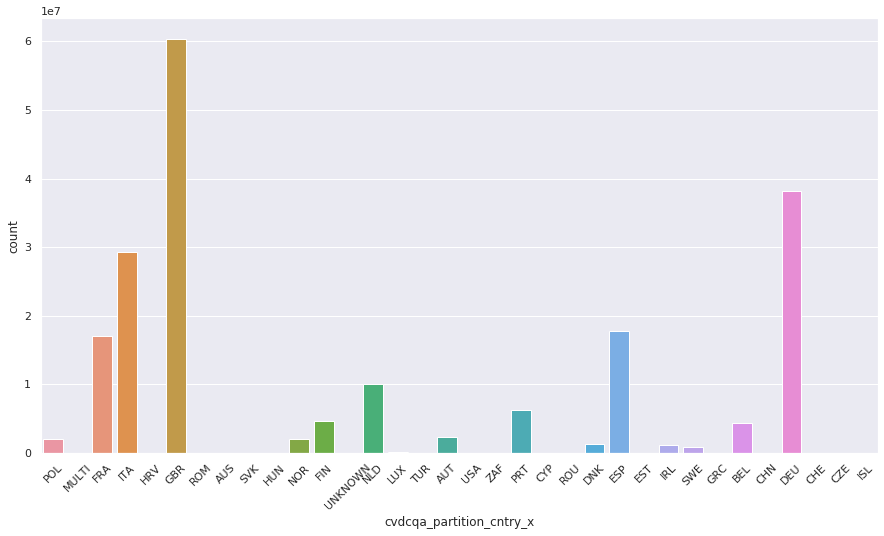

In [50]:
#set grid and font styles
sns.set(style="darkgrid")
#sns.set(font_scale=1.5)

#hourly distribution of messages 
size  = (15, 8)
fig, ax = plt.subplots(figsize = size)
plt.xticks(rotation=45)
#ax = sns.distplot("hour","count", data=hp1, palette="plasma")
ax = sns.barplot(x="cvdcqa_partition_cntry_x", y='count', data=TSdf);

In [ ]:
# For messages that have country code MULTI, how many have: 
# All EU 5 country (GBR, ITA, ESP, FRA, DEU)
# All non-EU 5 countries
# other (mix of EU 5 and non EU 5)
# confirm field name

In [ ]:
#read trip summary output

In [10]:
EU_multi = pd.read_csv('file:////s/lguerra5/EU_multi_TS.txt', names=['d1','vin','d2'], skiprows=1, sep='|')

In [13]:
EU_multi

vin
0    6FPPXXMJ2PKY19534
1    WF01XXERK1JM12674
2    WF0FXXGAHFKK16364
3    WF0JXXGAHJJB71738
4    WF0JXXGAHJJU28445
..                 ...
194  WF0NXXGCHNJT79601
195  WF0NXXGCHNKL35518
196  WF0PXXGCHPKJ22444
197  WF0PXXGCHPKK55555
198  WF0SXXWPGSJJ18629

[199 rows x 1 columns]

In [12]:
EU_multi.drop(columns=['d1', 'd2'], inplace = True)

In [14]:
EU_multi.vin.nunique()

199

In [12]:
#read TCU4G output

In [15]:
EU_cc = pd.read_csv('file:////s/lguerra5/EU_multi_vins_array.txt', names=['d1','vin','customer_countries','d2'], skiprows=1, sep='|', converters={'customer_countries': lambda x: x[1:-1].split(',')})

In [16]:
EU_cc.drop(columns=['d1', 'd2'], inplace = True)

In [15]:
EU_cc.dtypes

vin                   object
customer_countries    object
dtype: object

In [16]:
EU_cc.vin.nunique()

303

In [19]:
EU_cc.shape

(303, 2)

In [17]:
# dropping ALL duplicte values 
EU_cc.drop_duplicates(subset ="vin", keep = "first", inplace = True)

In [20]:
EU_cc.customer_countries[1][1]

'GBR'

In [18]:
EU_combined = EU_multi.merge(EU_cc, on='vin')

In [19]:
EU_combined.head()

vin customer_countries
0  6FPPXXMJ2PKY19534         [ROU, BEL]
1  WF01XXERK1JM12674         [DEU, BEL]
2  WF0FXXGAHFKK16364         [BEL, GBR]
3  WF0JXXGAHJJB71738         [BEL, GBR]
4  WF0JXXGAHJJU28445         [BEL, GBR]

In [20]:
EU_combined.shape

(199, 2)

In [24]:
#EU_combined.customer_countries[1][0].isin(["GBR", "ITA", "ESP", "FRA", "DEU"])
EU_combined.customer_countries[1][0] in ["GBR", "ITA", "ESP", "FRA", "DEU"]

True

In [25]:
a = EU_combined.customer_countries[18]

In [26]:
a

['ESP', 'GBR']

In [27]:
len(a)

2

In [29]:
len(set(a) & set(EU5))

2

In [33]:
len(EU_combined.vin)

253

In [23]:
EU5 = ["GBR", "ITA", "ESP", "FRA", "DEU"]

In [24]:
no_eu5 = 0
all_eu5 = 0
mix = 0

In [25]:
for i in range(len(EU_combined.vin)):
    a = EU_combined.customer_countries[i]
    n_matches = len(set(a) & set(EU5))
    if n_matches == 0:
        no_eu5 = no_eu5+1
    elif n_matches == len(a):
        all_eu5 = all_eu5+1
    else:
        mix = mix+1

In [26]:
print("Count with No EU5 countries: ", no_eu5)
print("Count with ALL EU5 countries: ", all_eu5)
print("Count with both EU5 and Non-EU5 countries: ", mix)

Count with No EU5 countries:  22
Count with ALL EU5 countries:  71
Count with both EU5 and Non-EU5 countries:  106


### Number of VINS per day EU

In [12]:
df1 = tripsum_EU.filter((tripsum_EU["trip_end_date"] > "2019-01-01"))

In [19]:
df1.show(5)

+-----------------+-------------+-------------+--------+----------+--------------------+------+------------------------+--------------------+--------------------+
|              vin|trip_end_date|trip_end_time| weekday|model_year|             veh_dsc|msg_id|vehicle_line_description|              engine|        transmission|
+-----------------+-------------+-------------+--------+----------+--------------------+------+------------------------+--------------------+--------------------+
|1FA6P8CF6L5104901|   2020-01-21|     13:48:19| Tuesday|      2020|Mustang 2015     ...|  9080|           S550n Mustang|Mod 5.0l-4v Dohc ...|6 Spd Man Trans-mt82|
|1FA6P8CF9L5110059|   2020-01-04|     13:53:25|Saturday|      2020|Mustang 2015     ...| 13793|           S550n Mustang|Mod 5.0l-4v Dohc ...|6 Spd Man Trans-mt82|
|1FA6P8CF9L5110059|   2020-01-04|     14:04:21|Saturday|      2020|Mustang 2015     ...| 13794|           S550n Mustang|Mod 5.0l-4v Dohc ...|6 Spd Man Trans-mt82|
|1FA6P8CF9L5110059|   

In [ ]:
#hp1 = tripsum_EU.groupBy(year("trip_end_date").alias("year"), month("trip_end_date").alias("month"), dayofmonth("trip_end_date").alias("day"),hour("trip_end_time").alias("hour")).count().orderBy("month").toPandas()

In [13]:
# breakdown by group/cancel/ride type total
ex1 = df1.groupby("trip_end_date").agg(countDistinct("vin"))

In [26]:
ex1.show(5)

+-------------+-------------------+
|trip_end_date|count(DISTINCT vin)|
+-------------+-------------------+
|   2019-06-04|              58710|
|   2019-05-08|              50174|
|   2019-11-18|             124402|
|   2019-09-22|              78782|
|   2020-01-21|             145768|
+-------------+-------------------+
only showing top 5 rows



In [14]:
exp1 = ex1.toPandas()

In [66]:
exp1.sort_values(by=['trip_end_date'], inplace = True)
exp1.reset_index(drop=True, inplace=True)

In [74]:
exp1["delta_vins"] = 0

In [79]:
exp1.tail()

trip_end_date  count(DISTINCT vin)  delta_vins
381    2020-01-18               130875      -16065
382    2020-01-19               110854      -20021
383    2020-01-20               146337       35483
384    2020-01-21               145768        -569
385    2020-01-22                    8           0

In [78]:
for i in range(len(exp1.trip_end_date)-1):
    if i > 0:
        exp1['delta_vins'][i] = exp1['count(DISTINCT vin)'][i] - exp1['count(DISTINCT vin)'][i-1]
    else:
        exp1['delta_vins'][i] = 0

/s/anaconda/users/lguerra5/miniconda2/envs/Py36Kernel/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/s/anaconda/users/lguerra5/miniconda2/envs/Py36Kernel/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [81]:
exp1.delta_vins.mean()

344.6373056994819

In [ ]:
#rename count column
#exp1.rename(columns={"A": "a", "B": "c"})

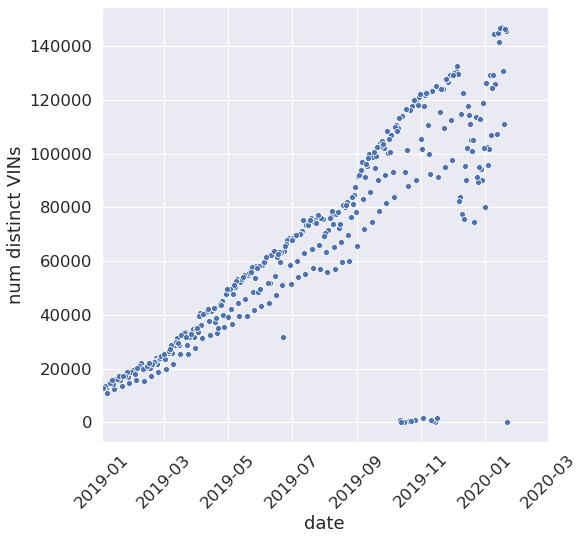

In [47]:
# set grid and font styles
sns.set(style="whitegrid")
sns.set(font_scale=1.5)

size  = (8,8)
fig, ax = plt.subplots(figsize = size)
plt.xticks(rotation=45)

#ax = sns.distplot("hour","count", data=hp1, palette="plasma")
ax = sns.scatterplot(x="trip_end_date", y="count(DISTINCT vin)", data=exp1);
#ax = sns.barplot(x="trip_end_date", y="count(DISTINCT vin)", data=exp1, palette="winter")

#legend = ax.legend(loc='upper right')
#legend.remove()
ax.set(xlabel='date', ylabel="num distinct VINs")

datemin = np.datetime64('2019-01', 'M')
datemax = np.datetime64('2020-03', 'M')
ax.set_xlim(datemin, datemax)

legend.set_title("Num Distinct Vins per Day")

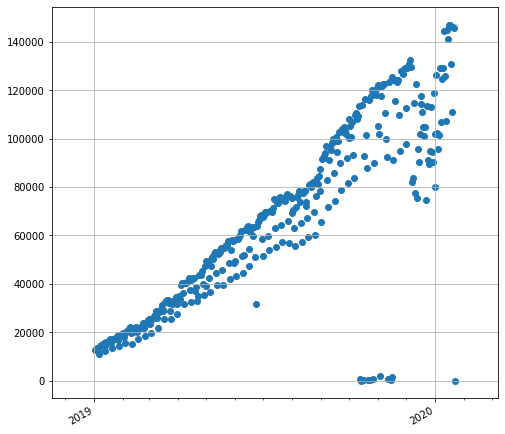

In [22]:
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

size  = (8,8)
fig, ax = plt.subplots(figsize = size)
plt.xticks(rotation=45)
ax.scatter('trip_end_date', 'count(DISTINCT vin)', data=exp1)

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
#ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
ax.grid(True)

# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()

plt.show()

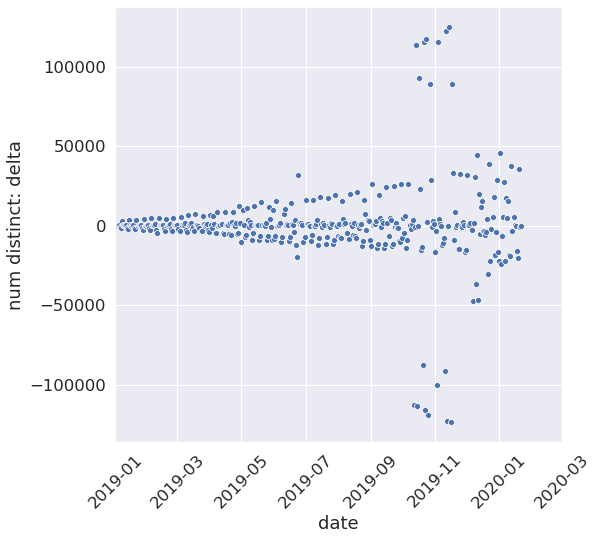

In [82]:
# set grid and font styles
sns.set(style="whitegrid")
sns.set(font_scale=1.5)

size  = (8,8)
fig, ax = plt.subplots(figsize = size)
plt.xticks(rotation=45)

#ax = sns.distplot("hour","count", data=hp1, palette="plasma")
ax = sns.scatterplot(x="trip_end_date", y="delta_vins", data=exp1);
#ax = sns.barplot(x="trip_end_date", y="count(DISTINCT vin)", data=exp1, palette="winter")

#legend = ax.legend(loc='upper right')
#legend.remove()
ax.set(xlabel='date', ylabel="num distinct: delta")

datemin = np.datetime64('2019-01', 'M')
datemax = np.datetime64('2020-03', 'M')
ax.set_xlim(datemin, datemax)

legend.set_title("Num Distinct Vins per Day")